#  **ICT303 - Assignment 1**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>**

**Email: <enter here your email address>**






## **1. Description**

In this homework, you will build, train, test and compare the performance of multilayer perceptrons (MLP) and convolutional neural networks (CNNs) on a multi-class classification problem.

For this task, you will use the image dataset available [here](https://drive.google.com/file/d/1nWRm-Npq_QE0j_sHyVVxVEx2Rb0Lc1zU/view?usp=sharing). This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):




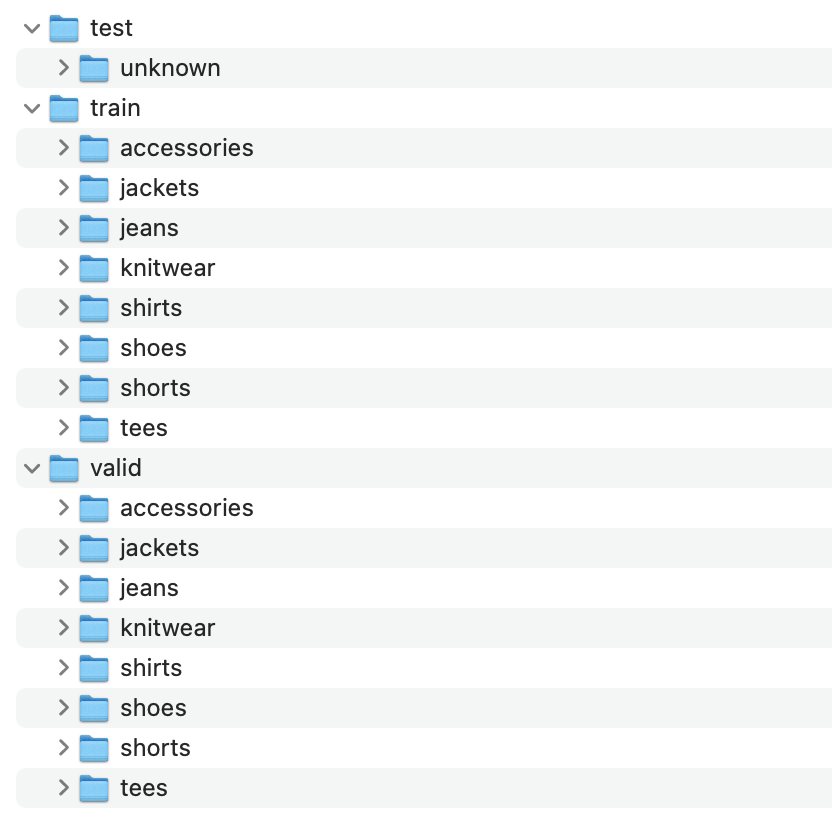


Your task is to:
1. Develop a multilayer perceptron model, train it and test it on the dataset. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
2. Implement VGG16, which a CNN architecture, train it and test it on the dataset. You must NOT use the pre-implemented VGG16 network in Pytorch. Instead, you have to implement all the layers and blocks yourself from scratch. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
3. Repeat step 2 above , but this time using the pretrained VGG16 network of PyTorch. **[20 Marks]**
4. For each of the tasks above, you need to finetune the hyper parameters to achieve the best performance possible.
5. Compare the performance of the three models.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

For Perth campus students, enrolled in internal model, you will be required to demonstrate your work in class. External students may be called to demonstrate the work to their tutor.

## **2. What do you need to submit**

You must submit:
- your source code, in the form of python libraries (i.e., .py files)
- A colab notebook that
 - Describes your solution and design choices. It is highly recommended to visually show the architecture of the networks you developed. You must include a discussion on how the hyper parameters affect performance and how did you select the ones you are currently using.
 - Demonstrates the training and testing of the machine learning models you developed.
 - Plots the training and validation curves for each model. You are requried to use TensorBoard for this task.
 - Analyzes the performance, in terms of Confusion Matrix and Mean Average Precision (MAE), of the methods, and how the hyper parameters affect this performance.
 - Allows the visualization of some classification results.

Important notes
- The performance of the machine learning models can be significantly affected by (1) the amount of data on which they are traiined, and (2) preprocessing, such as normalization, of the data (I will talk about this in class).
- Your program must be structured following what we have seen in the labs. In other words, you must use Object-oriented Programming and have a class for the data, a class for the model, a class for the trainer. You are allowed to reuse code you create in the labs. Also, you are allowed (in fact sometimes you should) reuse code across different models. For example, you only need one class to manage the data, whether you are using MLPs or CNNs (VGG16 in our case).
- We have zero tolerance for plagaiarsism and misconduct (e.g., asking AI to do the work for you).


Load tensorboard

In [ ]:
%load_ext tensorboard
print("tensorboard extension loaded")

My own VGG16 implementation:

Import Dependencies

In [ ]:
import os # for some OS ops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.optim as optim
import time
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder # The data set that we will use
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
print("Dependencies Loaded!")

In [ ]:
!git clone https://github.com/Aithusa712/GoogleColab.git

In [ ]:
# For Linux
%cd GoogleColab/Assignment\ 1/

In [ ]:
# For Windows
%cd "GoogleColab/Assignment 1"

In [ ]:
%ls

MLP class implementation based on MLP architecture
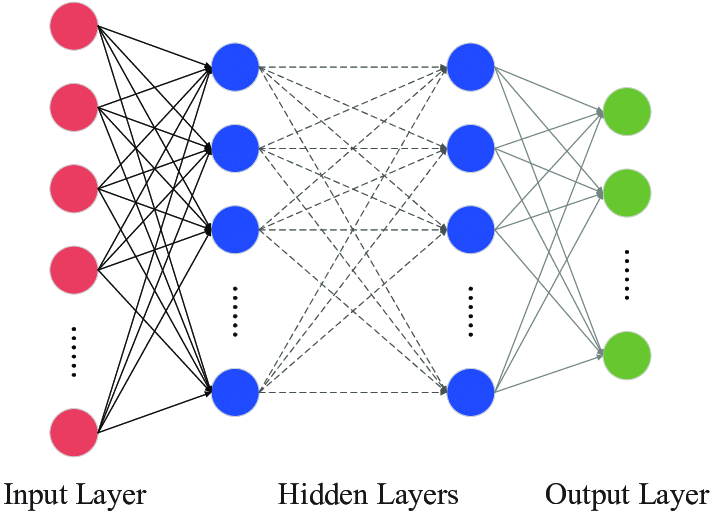

In [ ]:
## The MLP class
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=224 * 224 * 3, outputSize=8, lr=0.01, class_weights=None, dropout_rate = 0.4, optimizer_type = "adam"):
    super().__init__()

    self.lr = lr
    self.class_weights = class_weights
    self.optimizer_type = optimizer_type
    self.dropout_rate = dropout_rate

    self.layers = nn.Sequential(
        nn.Flatten(),
        # Input and First hidden Layer
        nn.Linear(inputSize, 512),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Second hidden Layer
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Output Layer
        nn.Linear(128, outputSize),
    )


  ## The forward step
  def forward(self, X):
    return self.layers(X)

  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss(weight=self.class_weights)
    return fn(y_hat, y)

  ## The optimization algorithm
  def configure_optimizers(self):
    if(self.optimizer_type=="adam"):
      return optim.Adam(self.parameters(), lr=self.lr)
    elif(self.optimizer_type=="sgd"):
      return optim.SGD(self.parameters(), lr=self.lr)
    else:
      return optim.Adam(self.parameters(), lr=self.lr)


myVGG16 class implementation based on VGG16 Architecture
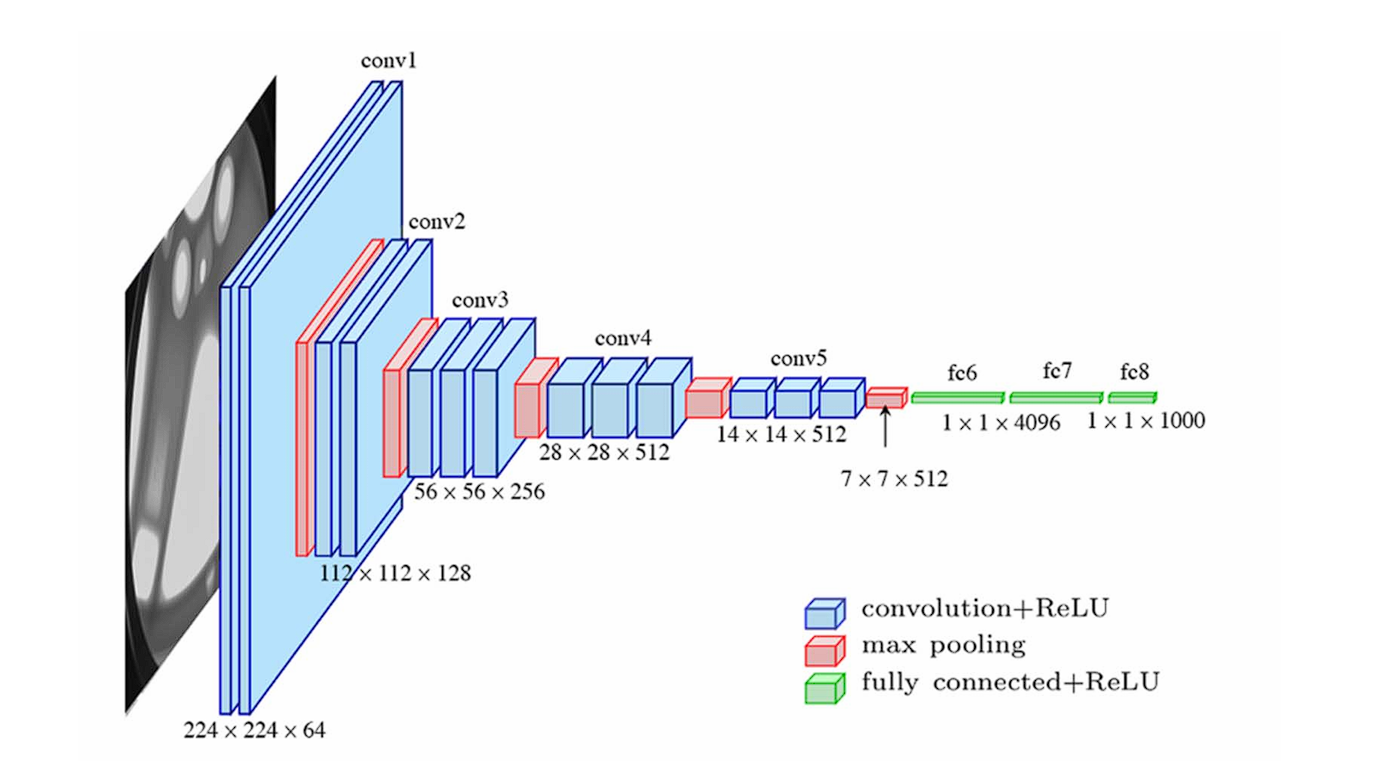

In [ ]:
class myVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-3, class_weights=None, dropout_rate=0.4, optimizer_type="adam"):
        super().__init__()

        self.lr = lr
        #self._init_weights()
        self.class_weights = class_weights
        self.optimizer_type = optimizer_type
        self.dropout_rate = dropout_rate

        # VGG-16 convolution blocks
        self.conv_layer = nn.Sequential(
            #conv1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),        # Convolution + ReLU
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),       # Convolution + ReLU
            #conv2
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),      # Convolution + ReLU
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            #conv3
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            #conv4
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU


            # conv5
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU

            nn.MaxPool2d(2, 2),                                           # Max Pooling
        )

        # For 224x224 input
        self.fc_layer = nn.Sequential(
          # fc6
          nn.Linear(512 * 7 * 7, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc7
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc8
          nn.Linear(4096, outputSize)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

    def loss(self, y_hat, y):
       return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
      if(self.optimizer_type=="adam"):
        return optim.Adam(self.parameters(), lr=self.lr)
      elif(self.optimizer_type=="sgd"):
        return optim.SGD(self.parameters(), lr=self.lr)
      else:
        return optim.Adam(self.parameters(), lr=self.lr)

'''
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
'''

Training Class

In [ ]:
class Trainer:

  def __init__(self, tb, n_epochs = 3):
    self.max_epochs = n_epochs
    self.writer = tb  # the tensorboard instance
    return

  def fit(self, model, data, validation_data):
    self.data = data
    self.validation_data = validation_data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    self.model     = model

    for epoch in range(self.max_epochs):
      print(f"\nEpoch {epoch + 1}/{self.max_epochs}")
      self.fit_epoch()
      self.validate_epoch()

      # Logging the average training loss so that it can be visualized in the tensorboard
      self.writer.add_scalar("Training Loss", self.avg_training_loss, epoch)
      self.writer.add_scalar("Validation Loss", self.avg_val_loss, epoch)

    print("Training process has finished")

  def fit_epoch(self):

    self.model.train()
    current_loss = 0.0
    self.avg_training_loss = 0.0

    # iterate over the DataLoader for training data
    for i, data in enumerate(self.data):
      # Get input
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device) # use GPU


      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t to the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statistics (average of the training loss over minibatches of 500 data items)
      current_loss += loss.item()

      # Adding training loss
      self.avg_training_loss += loss.item()

      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    # The average training loss
    self.avg_training_loss = self.avg_training_loss / i # to get the average
    print(f"Training Loss (avg): {self.avg_training_loss:.4f}")

  def validate_epoch(self):

    self.model.eval()
    total_loss = 0.0
    self.avg_val_loss = 0.0

    with torch.no_grad():
      # iterate over the DataLoader for training data
      for i, data in enumerate(self.validation_data):
        # Get input
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device) # use GPU

        # get output from the model, given the inputs
        outputs = self.model(inputs)

        # get loss for the predicted output
        loss = self.model.loss(outputs, target)

        total_loss += loss.item()

      # The average training loss
      self.avg_val_loss = total_loss / (i + 1) # to get the   average
      print(f"Validation Loss (avg): {self.avg_val_loss:.4f}")

Load images into preprocessed data (fixes a problem with slow training for my setup)

In [ ]:
class myDataLoader:
    def __init__(self, train_dir="data/train", val_dir="data/valid", image_size=(224, 224)):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))
        ])

    def get_data(self):
        # Load datasets with ImageFolder
        train_dataset = ImageFolder(root=self.train_dir, transform=self.transform)
        val_dataset = ImageFolder(root=self.val_dir, transform=self.transform)

        # Extract and save training data
        train_images, train_labels = zip(*[(img, label) for img, label in train_dataset])
        train_images = torch.stack(train_images)
        train_labels = torch.tensor(train_labels)
        torch.save((train_images, train_labels), "train_tensor.pt")
        print("Training data saved as train_tensor.pt")

        # Extract and save validation data
        val_images, val_labels = zip(*[(img, label) for img, label in val_dataset])
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        torch.save((val_images, val_labels), "val_tensor.pt")
        print("Validation data saved as valid_tensor.pt")

        # Save class names
        with open("classes.txt", "w") as f:
            for class_name in train_dataset.classes:
                f.write(f"{class_name}\n")

    def load_data(self):
        train_images, train_labels = torch.load("train_tensor.pt")
        val_images, val_labels = torch.load("val_tensor.pt")
        with open("classes.txt", "r") as f:
            class_names = [line.strip() for line in f]
        return train_images, train_labels, val_images, val_labels, class_names

    def get_class_weights(self, labels, num_classes, device):
        label_counts = Counter(labels.tolist())
        class_weights = [(1 / label_counts[i]) ** 0.5 for i in range(num_classes)]
        return torch.tensor(class_weights, dtype=torch.float).to(device)

Main Program

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Prepare / Load Data
print("Preparing and Loading Data....")
data_loader = myDataLoader()
data_loader.get_data()
train_images, train_labels, val_images, val_labels, class_names = data_loader.load_data()
print("Finished loading!")

# Create Datasets and DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=12, pin_memory=True)

# Compute class weights
num_classes = len(class_names)
class_weights = data_loader.get_class_weights(train_labels, num_classes, device)

# Initialize Model (Choose one)
mlp_model = MLP(outputSize=num_classes, lr=lr, class_weights=class_weights,).to(device)
myVGG16_model = myVGG16(outputSize=num_classes, lr=lr, class_weights=class_weights).to(device)

# Train




print("Training complete.")

Tune Hyperparameters

In [ ]:
# Hyperparameters tuning
batch_size = 64 #32
n_epochs = 15
lr = .02 #1e-4 #3e-4

Train MLP Model

In [ ]:
mlp_writer = SummaryWriter('runs/mlp')
# Train MLP model
mlp_trainer = Trainer(mlp_writer, n_epochs)
mlp_trainer.fit(mlp_model, train_loader, val_loader)

Train myVGG16 Model

In [ ]:
vgg16_writer = SummaryWriter('runs/my_vgg16')
# Train myVGG16 Model
vgg16_trainer = Trainer(vgg16_writer, n_epochs)
vgg16_trainer.fit(myVGG16_model, train_loader, val_loader)
vgg16_writer.close()

Test Model Accuracy

In [ ]:
def test_model_on_device(test_device, dataloader, model):
    model.to(test_device)
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(test_device), labels.to(test_device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end = time.time()
    print(f"Accuracy: {100 * correct / total:.2f}% - Inference Time: {end - start:.2f}s")





In [ ]:
# MLP implementation
print("MLP:")

if torch.cuda.is_available():
    test_model_on_device(device, val_loader, myVGG16_model)
else:
    test_model_on_device(device, val_loader, myVGG16_model)


In [ ]:
# my VGG16 implementation
print("myVGG16:")

if torch.cuda.is_available():
    test_model_on_device(device, val_loader, myVGG16_model)
else:
    test_model_on_device(device, val_loader, myVGG16_model)


In [ ]:
# Load class names from training (saved earlier)
with open("classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_dataset = ImageFolder(root='data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


mlp_model.eval()
myVGG16_model.eval()
mlp_model.to(device)
myVGG16_model.to(device)

test_images = []
with torch.no_grad():
    for inputs, _ in test_loader:
        for img in inputs:
            test_images.append(img)


inputs = torch.stack(test_images).to(device)

# Get predictions
with torch.no_grad():
    outputs_mlp = mlp_model(inputs)
    outputs_vgg = myVGG16_model(inputs)

_, predicted_mlp = torch.max(outputs_mlp, 1)
_, predicted_vgg = torch.max(outputs_vgg, 1)

# Plot predictions
fig, axs = plt.subplots(2, 8, figsize=(14, 5))
fig.suptitle("Top: MLP model | Bottom: VGG16 model\n7 Epochs, Batch size 64, lr = 3e-4",
             fontsize=14, x=0.5, ha='center')

for i in range(8):
    # Unnormalize
    img = inputs[i].cpu() * 0.5 + 0.5
    img_np = img.permute(1, 2, 0).numpy()

    # Get prediction indices
    mlp_pred_idx = predicted_mlp[i].item()
    vgg_pred_idx = predicted_vgg[i].item()

    # Get label names
    mlp_label = class_names[mlp_pred_idx] if mlp_pred_idx < len(class_names) else "Invalid"
    vgg_label = class_names[vgg_pred_idx] if vgg_pred_idx < len(class_names) else "Invalid"

    # MLP prediction (top row)
    axs[0, i].imshow(img_np)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"MLP: {mlp_label}", fontsize=9, pad=10)

    # VGG16 prediction (bottom row)
    axs[1, i].imshow(img_np)
    axs[1, i].axis('off')
    axs[1, i].set_title(f"VGG16: {vgg_label}", fontsize=9, pad=10)

# Layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)
plt.show()

In [ ]:
#torch.save(mlp_model.state_dict(), "mlp_model.pth")  # For MLP
#torch.save(myVGG16_model.state_dict(), "vgg16_model.pth")  # For VGG16

In [ ]:
tensorboard --logdir runs